## Preparing the data
Preparing the dataset for further usage.


In [1]:
import cv2 as cv
from matplotlib import pyplot as plt
import pathlib
import numpy as np 

Getting the data.

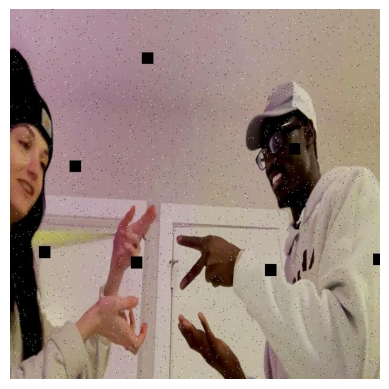

In [2]:
data_dir_path = "C:/Users/user/Desktop/sk_27/data/Dataset_textannot/"
train_dir = pathlib.Path(data_dir_path + "/train/").with_suffix('')

image_files = list(train_dir.glob('*.jpg'))

sample_img_path = str(image_files[103])
sample_img = cv.imread(sample_img_path, cv.IMREAD_COLOR)

plt.imshow(cv.cvtColor(sample_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()



The data consist of images files and respective annotation files. Each annotation file has one or more lines in which we can find the class and bounding box coordinates:


In [3]:
sample_annotation_path = sample_img_path[0:-4] + '.txt'
with open(sample_annotation_path) as f:
    print(f.readlines())

['2 0.33828125 0.6125 0.1171875 0.17421875\n', '2 0.53046875 0.6859375 0.16171875 0.15703125']


In [4]:
import os

def list_files_for_directory(data_path, image_ext='.jpg'):
    files = []
    discarded = 0
    class_counts = [0, 0, 0]  # Counts for each class (0, 1, 2)

    for filename in os.listdir(data_path):
        if filename.endswith('.txt'):
            # Read the annotation file
            annotation_path = os.path.join(data_path, filename)
            with open(annotation_path, 'r') as annotation_file:
                lines = annotation_file.readlines()

                # Check if the annotation file is empty or has invalid content
                if not lines:
                    discarded += 1
                    continue

                # Extract the class label if it's present on the first line
                if lines[0].strip():
                    class_label = int(lines[0].split()[0])
                    class_counts[class_label] += 1

            # Construct the path to the corresponding image file
            base_name = os.path.splitext(filename)[0]
            image_path = os.path.join(data_path, base_name + image_ext)
            if os.path.isfile(image_path):
                files.append(image_path)

    print(f"{discarded} file(s) discarded")
    print(f"Class counts: Class 0 - {class_counts[0]}, Class 1 - {class_counts[1]}, Class 2 - {class_counts[2]}")
    
    return files


The code generates a list of all the images along with the full path, from the directory specified.

In [5]:
train_data_path = 'C:/Users/user/Desktop/sk_27/data/Dataset_textannot/train/'
train_files = list_files_for_directory(train_data_path)

4269 file(s) discarded
Class counts: Class 0 - 2070, Class 1 - 2629, Class 2 - 1985


In [6]:
train_files

['C:/Users/user/Desktop/sk_27/data/Dataset_textannot/train/0001_png.rf.02e05ccaf2bf8a0065be0ad8484f68cb.jpg',
 'C:/Users/user/Desktop/sk_27/data/Dataset_textannot/train/0001_png.rf.4504a044b457dd63303eaeefe4673478.jpg',
 'C:/Users/user/Desktop/sk_27/data/Dataset_textannot/train/0001_png.rf.5e22fcd367ffc26ff60b1c51ad0f660c.jpg',
 'C:/Users/user/Desktop/sk_27/data/Dataset_textannot/train/0001_png.rf.c2b53e01064aabbf825f06dd3a017500.jpg',
 'C:/Users/user/Desktop/sk_27/data/Dataset_textannot/train/0001_png.rf.f1358fc7c4dffd593d148b2fa661b757.jpg',
 'C:/Users/user/Desktop/sk_27/data/Dataset_textannot/train/0003_png.rf.2343a9aaae8f45b68bcdb31d529c5974.jpg',
 'C:/Users/user/Desktop/sk_27/data/Dataset_textannot/train/0003_png.rf.8affb45c720cbb35f4a2130c5b8671b9.jpg',
 'C:/Users/user/Desktop/sk_27/data/Dataset_textannot/train/0003_png.rf.9bcfca705d67775d244ac7f85110d31d.jpg',
 'C:/Users/user/Desktop/sk_27/data/Dataset_textannot/train/0003_png.rf.b3d0db1b6e9b64d2d8604139ee10306d.jpg',
 'C:/Users

Alright now let's try and plot an image along with the box aroung the object of interest to verify the annotations.


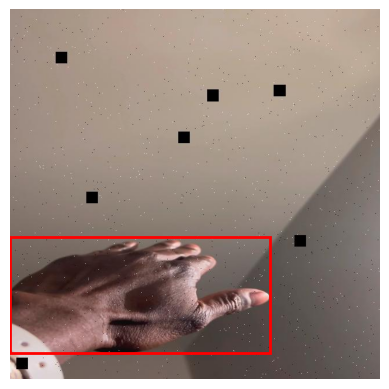

In [7]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Sample image path
sample_img_path = "C:/Users/user/Desktop/sk_27/data/Dataset_textannot/train/IMG_7043_MOV-137_jpg.rf.222f213d1cc04c1141e64347ec3e270a.jpg"
# Sample annotation file path
sample_annotation_path = "C:/Users/user/Desktop/sk_27/data/Dataset_textannot/train/IMG_7043_MOV-137_jpg.rf.222f213d1cc04c1141e64347ec3e270a.txt"

# Load the sample image
sample_img = cv2.imread(sample_img_path)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

# Read the annotation file
with open(sample_annotation_path, "r") as f:
    lines = f.readlines()

# Assuming there's only one annotation in the file
if lines:
    annotation = lines[0].split()
    category_id, x_center, y_center, width, height = map(float, annotation)

    # Get the actual dimensions of the image
    image_height, image_width, _ = sample_img.shape

    # Convert percentages to pixel coordinates
    x1 = int((x_center - width / 2) * image_width)
    y1 = int((y_center - height / 2) * image_height)
    x2 = int((x_center + width / 2) * image_width)
    y2 = int((y_center + height / 2) * image_height)

    # Create a Rectangle patch
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="r", facecolor="none")

    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(sample_img)

    # Add the Rectangle patch to the axes
    ax.add_patch(rect)

    # Show the plot
    plt.axis("off")
    plt.show()


Let's create a tensorflow dataset with the images. This is going to ensure that our data works smoothly and efficiently in TensorFlow.


In [8]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disabling verbose tf logging

# uncomment the following line if you want to force CPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
print(tf.__version__)


2.10.0


In [9]:
input_size = 640

def data_load(files, full_data_path = "C:/Users/user/Desktop/sk_27/data/Dataset_textannot/train", image_ext = ".jpg"):
    X = []
    Y = []

    for file in files:
        img = cv.imread(os.path.join(full_data_path, file ), cv.IMREAD_GRAYSCALE)

        k = 1

        base_filename = os.path.splitext(file)[0]
        annotation_file = os.path.join(full_data_path, base_filename + ".txt")  
        with open(annotation_file, 'r') as fp:
            line = fp.readlines()[0]
            if line[0] == '0':
                k = 0

            box = np.array(line[1:].split(), dtype=float)

        
        img = img.astype(float) / 255.
        box = np.asarray(box, dtype=float) / input_size
        label = np.append(box, k)

        X.append(img)
        Y.append(label)

    X = np.array(X)
    
    X = np.expand_dims(X, axis=3)

    X = tf.convert_to_tensor(X, dtype=tf.float32)

    Y = tf.convert_to_tensor(Y, dtype=tf.float32)

    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result

In [10]:
raw_train_ds = data_load(train_files)

Now let's get the lists of test and validation data as well.


In [11]:
test_data_path = "C:/Users/user/Desktop/sk_27/data/Dataset_textannot/test/"
test_files = list_files_for_directory(test_data_path)

134 file(s) discarded
Class counts: Class 0 - 70, Class 1 - 62, Class 2 - 63


In [12]:
raw_test_ds = data_load(test_files)

In [13]:
valid_data_path = "C:/Users/user/Desktop/sk_27/data/Dataset_textannot/valid"
valid_files = list_files_for_directory(valid_data_path)

251 file(s) discarded
Class counts: Class 0 - 131, Class 1 - 119, Class 2 - 103


In [14]:
raw_valid_ds = data_load(valid_files)

In [15]:
CLASSES = 3
BATCH_SIZE = 4
def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]), CLASSES), [label[0], label[1], label[2], label[3]])

In [16]:

def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # The dataset be repeated indefinitely.
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


In [17]:
train_ds = tune_training_ds(raw_train_ds)

In [18]:
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(valid_files) // 4)
    dataset = dataset.repeat()
    return dataset

In [19]:
validation_ds = tune_validation_ds(raw_valid_ds)

Let's do some inspection of the training dataset now. 

In [20]:
# plt.figure(figsize=(20, 10))
# for images, labels in train_ds.take(1):
#     for i in range(BATCH_SIZE):
#         ax = plt.subplot(4, BATCH_SIZE//4, i + 1)
#         label = labels[0][i]
#         box = (labels[1][i] * input_size)
#         box = tf.cast(box, tf.int32)

#         image = images[i].numpy().astype("float") * 640.0
#         image = image.astype(np.uint8)
#         image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

#         if label[0] == 1:  # Class 1
#             color = (0, 0, 255)  # Red
#         elif label[1] == 1:  # Class 2
#             color = (0, 255, 0)  # Green
#         else:                 # Class 3
#             color = (255, 0, 0)  # Blue


#         cv.rectangle(image_color, box.numpy(), color, 2)

#         plt.imshow(image_color)
#         plt.axis("off")

# The Model
Our model needs to accomplish two tasks:
1. Regression of the bound box coordinates
2. Classification of the object label

Therefore the model has two outputs: namely the object label and the object bound box and the model must combine the tasks of classification and regression.



In [21]:
DROPOUT_FACTOR = 0.5

def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    return x

def build_model_adaptor(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x

def build_classifier_head(inputs):
    return tf.keras.layers.Dense(CLASSES, activation='softmax', name = 'classifier_head')(inputs)

def build_regressor_head(inputs):
    return tf.keras.layers.Dense(units = '4', name = 'regressor_head')(inputs)

def build_model(inputs):
    
    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' }, 
              metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

    return model

In [22]:
model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 640, 640, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 638, 638, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 average_pooling2d (AveragePool  (None, 319, 319, 16  0          ['conv2d[0][0]']                 
 ing2D)                         )                                                             

In [1]:
# from keras.utils.vis_utils import plot_model
# tf.keras.utils.plot_model(
# model, to_file='model.png', show_shapes=False, show_dtype=False,
# show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
# )
# plot_model(model, show_shapes=True, show_layer_names=True)

## Model Training 

In [36]:
EPOCHS = 10

history = model.fit(train_ds,
                    steps_per_epoch=(len(train_files) // BATCH_SIZE),
                    validation_data=validation_ds, validation_steps=1, 
                    epochs=EPOCHS)

: 

: 